# Multi Tool Agent

This notebook demonstrates an agent that has many tools available to answer questions. If a tool isn't found, then it is able to generate novel Cypher to answer the question.

In [1]:
import sys

DIR_SHIFT = "../../"
sys.path.append(DIR_SHIFT)

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import asyncio

from IPython.display import Image, display
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from ps_genai_agents.components.state import OutputState
from ps_genai_agents.retrievers.cypher_examples import YAMLCypherExampleRetriever
from ps_genai_agents.workflows.multi_agent import create_multi_tool_workflow

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

## Neo4j Graph

In [5]:
graph = Neo4jGraph(enhanced_schema=True)

In [6]:
print(graph.get_schema)

Node properties:
- **Recipe**
  - `id`: STRING Example: "8096211"
  - `name`: STRING Example: "veggie rainbow picnic pie"
  - `description`: STRING Example: "packed with veggies, feta and egg, this vegetarian"
  - `skillLevel`: STRING Example: "easy"
  - `cookingTimeMinutes`: INTEGER Example: "100"
  - `preparationTimeMinutes`: INTEGER Example: "45"
- **Ingredient**
  - `name`: STRING Example: "'00' flour"
- **Keyword**
  - `name`: STRING Example: "pesto"
- **DietType**
  - `name`: STRING Example: "dairy-free"
- **Author**
  - `name`: STRING Example: ""
- **Collection**
  - `name`: STRING Example: "15 minutes or less"
- **CypherQuery**
  - `question`: STRING Example: "What are some chocolate cakes I could make?"
  - `cypherStatement`: STRING Example: "MATCH (:Collection {name: 'Chocolate cake'})<-[:CO"
  - `embeddingModel`: STRING Available options: ['text-embedding-ada-002']
Relationship properties:

The relationships:
(:Recipe)-[:CONTAINS_INGREDIENT]->(:Ingredient)
(:Recipe)-[:KEYWOR

## LLM Connections

In [7]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Additional Configurations

In [8]:
from data.bbc_recipes.queries import get_cypher_statements_dictionary, get_tool_schemas
from ps_genai_agents.components.text2cypher import get_text2cypher_schema

In [9]:
cypher_query_yaml_file_path = DIR_SHIFT + "data/bbc_recipes/queries/queries.yml"

cypher_queries_for_tools = (
    get_cypher_statements_dictionary()
)  # this is used to find Cypher queries based on a name

tool_schemas = (
    get_tool_schemas() + [get_text2cypher_schema()]
)  # these are Pydantic classes that define the available Cypher queries and their parameters

cypher_example_retriever = YAMLCypherExampleRetriever(
    cypher_query_yaml_file_path=cypher_query_yaml_file_path
)

In [10]:
scope_description = "This application may answer questions related to cooking recipes and their authors."

In [11]:
agent = create_multi_tool_workflow(
    llm=llm,
    graph=graph,
    tool_schemas=tool_schemas,
    predefined_cypher_dict=cypher_queries_for_tools,
    scope_description=scope_description,
    cypher_example_retriever=cypher_example_retriever,
    llm_cypher_validation=False,
    attempt_cypher_execution_on_final_attempt=True,
    default_to_text2cypher=False,
)

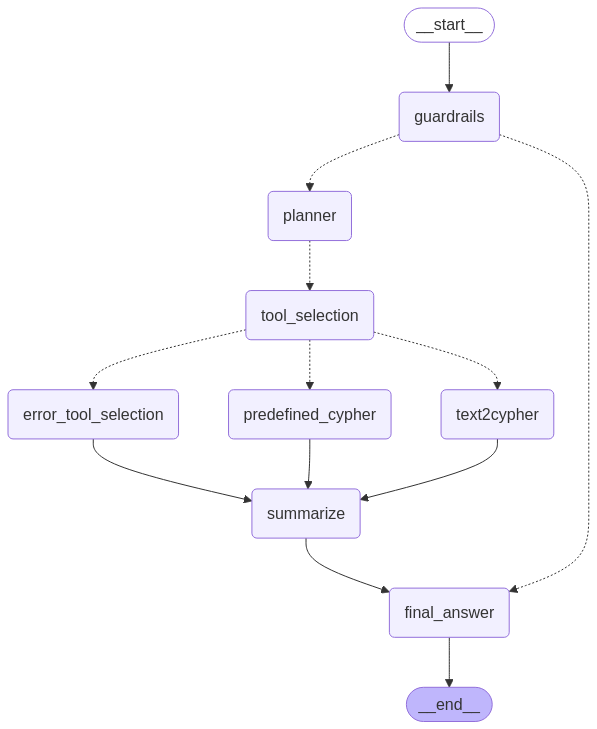

In [12]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Questions

In [13]:
async def ask_question(question: str, debug: bool = False) -> OutputState:
    """wrapper to simplify asking questions in the notebook."""

    async def ask():
        response = await agent.ainvoke({"question": question}, debug=debug)
        return response

    return asyncio.run(ask())


def print_answer(response: OutputState) -> None:
    print(response.get("question"))
    print(response.get("answer"))


def print_cypher_queries(response: OutputState) -> None:
    [
        print(c.get("task", "") + "\n\n" + c.get("statement", "") + "\n\nParameters:\n" + str(c.get("parameters", "")))
        for c in response.get("cyphers", list())
    ] if response.get("cyphers") is not None else ""


def print_cypher_results(response: OutputState) -> None:
    [
        (
            print(c.get("task", "") + "\n\n"),
            [print(r) for r in c.get("records", "")],
            print("\n\n"),
        )
        for c in response.get("cyphers", list())
    ]


def print_viz_results(response: OutputState) -> None:
    [
        (
            print(v.get("task") + "\n\n" + v.get("chart_description") + "\n\n"),
            display(v.get("chart")),
        )
        for v in response.get("visualizations")
    ]

### Text2Cypher Only Question

We don't have tools that address these questions entirely, so we will need to use Text2Cypher to answer correctly. 

In [ ]:
response = await agent.ainvoke(
    {
        "question": "How many authors have written a recipe?"
    },
    debug=False,
)

In [15]:
print_answer(response)

How many authors have written a recipe?
**303 authors have written a recipe.**


In [16]:
print_cypher_queries(response)

How many unique authors are there in the dataset?

MATCH (a:Author)
RETURN count(DISTINCT a.name) AS uniqueAuthors

Parameters:
None
How many recipes are there in the dataset?

MATCH (r:Recipe)
RETURN count(r) AS numberOfRecipes

Parameters:
None


In [17]:
print(response.get("steps"))

['guardrails', 'planner', 'generate_cypher', 'validate_cypher', 'execute_cypher', 'text2cypher', 'generate_cypher', 'validate_cypher', 'execute_cypher', 'text2cypher', 'summarize', 'final_answer']


### Question Using Predefined Cypher Tool

We can use the `get_most_common_ingredients_an_author_uses` tool to address the following question. This reduces the number of LLM calls we have to make since we're not relying on Text2Cypher.

In [18]:
q2 = await agent.ainvoke(
    {"question": "What ingredients does emma lewis like to use most?"}, debug=False
)

In [19]:
print_answer(q2)

What ingredients does emma lewis like to use most?
- **Olive oil**: 39 recipes
- **Butter**: 37 recipes
- **Garlic clove**: 29 recipes
- **Onion**: 24 recipes
- **Egg**: 21 recipes
- **Lemon**: 21 recipes
- **Vegetable oil**: 18 recipes
- **Plain flour**: 15 recipes
- **Caster sugar**: 13 recipes
- **Thyme**: 11 recipes


In [20]:
print_cypher_queries(q2)

What are the most frequently used ingredients by Emma Lewis?


MATCH (:Author {name: $author})-[:WROTE]->(:Recipe)-[:CONTAINS_INGREDIENT]->(i:Ingredient)
RETURN i.name as name, COUNT(*) as numRecipes
ORDER BY numRecipes DESC
LIMIT 10


Parameters:
{'author': 'emma lewis'}


In [25]:
print(q2.get("steps"))

['guardrails', 'planner', 'execute_predefined_cypher', 'summarize', 'final_answer']


### Question Using Predefined Cypher and Text2Cypher

This query requires Text2Cypher to answer which vehicle has the highest number of complaints but may use the `get_all_vehicle_names` tool to answer which vehicles the user may ask about.

In [21]:
q3 = await agent.ainvoke(
    {
        "question": "What are some easy recipes I can make? Also can you share how many ingredients you know about?"
    },
    debug=False,
)

In [22]:
print_answer(q3)

What are some easy recipes I can make? Also can you share how many ingredients you know about?
- **Apricot & Pistachio Frangipane Blondies**
- **Camomile Tea with Honey**
- **Pastry Snakes**
- **Quick Banana Ice Cream Sandwiches**
- **Red Onion with Peanut Butter & Chilli**

I know about 3068 ingredients.


In [23]:
print_cypher_queries(q3)

What are some easy recipes I can make?


MATCH (r:Recipe {skillLevel: "easy"})
RETURN r.name as name
LIMIT $number_of_recipes


Parameters:
{'number_of_recipes': 5}
How many ingredients do you know about?

MATCH (i:Ingredient)
RETURN count(i) AS numberOfIngredients

Parameters:
None


In [24]:
print(q3.get("steps"))

['guardrails', 'planner', 'execute_predefined_cypher', 'generate_cypher', 'validate_cypher', 'execute_cypher', 'text2cypher', 'summarize', 'final_answer']
